#  Build a semantic content recommendation system with Amazon SageMaker

[git_source](https://github.com/Aduzona/amazon-sagemaker-examples/blob/main/introduction_to_applying_machine_learning/ntm_20newsgroups_topic_modeling/ntm_20newsgroups_topic_model.ipynb)

[aws_handson_lab](https://aws.amazon.com/getting-started/hands-on/semantic-content-recommendation-system-amazon-sagemaker/4/)

**Introduction**

In this lab, you learn how to build a semantic, content recommendation system that combines topic modeling and nearest neighbor techniques for information retrieval using Amazon SageMaker built-in algorithms for [Neural Topic Model (NTM)](https://docs.aws.amazon.com/sagemaker/latest/dg/ntm.html) and [K-Nearest Neighbor (K-NN)](https://docs.aws.amazon.com/sagemaker/latest/dg/k-nearest-neighbors.html).

Information retrieval is the science of searching for information in a document, searching for documents themselves, or searching for metadata that describe data. This lab combines the techniques of topic modeling and nearest neighbor for information retrieval. This approach uses topic modeling to generate semantic distribution vectors representing the meaning of documents by topics, and then uses the nearest neighbor technique to index topic vectors to retrieve similar documents for a given input document based on topic similarity. By using Amazon SageMaker built-in algorithms, you do not need to label data and the information retrieval is based on semantic meaning similarity instead of simple string matching.

Amazon SageMaker is a fully managed end-to-end machine learning platform that covers the entire lifecycle of machine learning. Amazon SageMaker NTM is an unsupervised learning algorithm that is used to organize a corpus of documents into topics that contain word groupings based on their statistical distribution. Amazon K-Nearest Neighbors (k-NN) is a non parametric, index-based, supervised learning algorithm that can be used for classification and regression tasks.

**Why use Amazon SageMaker for information retrieval?**

One of the key components in Amazon SageMaker is a list of highly scalable built-in algorithms. This lab uses Amazon SageMaker Neural Topic Model (NTM) Algorithm and Amazon SageMaker K-Nearest Neighbors (K-NN) Algorithm to combine information retrieval techniques and build a recommendation system.

Some of the key reasons to use Amazon SageMaker for your information retrieval are:

Scalable Training: SageMaker fully manages the underlying infrastructure needed to train models at scale by handling the setup of the instances, data movement between storage and compute, as well as between compute instances and the de-provisioning of compute once the job is completed. With spot training, you can save up to 90% in training costs.
Scalable Deployment: Once your models are trained, SageMaker can fully manage both offline (batch) inferences and online deployments of your trained models by creating a hosted endpoint for you. SageMaker handles the automatic scaling of your endpoints to scale up and down based on the incoming traffic.
Monitoring: With Amazon SageMaker Model Monitor, you can monitor your model endpoints for drift in your data and emit alarms when data drift is detected to suggest retraining your models.
Fully Managed Hyperparameter Tuning: Training ML models often requires a time consuming process of tuning hyperparameters. SageMaker manages hyper-parameter tuning jobs for you; you simply select the number of tuning jobs you want to run in parallel and in total, the metrics you want to monitor and Amazon Sagemaker takes care of the rest.

## Download and prepare dataset

In this module, you download your dataset, preprocess the dataset, separate the dataset into training and validation, then stage the dataset in your Amazon S3 bucket.

Your ML model will be trained on the 20newsgroups dataset that contains 20,000 newsgroup posts on 20 topics. The 20newsgroups dataset is curated by Carnegie Mellon University School of Computer Science and publically available from scikit-learn.

### 1.  Fetch the dataset

To prepare the data, train the ML model, and deploy it, you must first import some libraries and define a few environment variables in your Jupyter notebook environment.

In [3]:
#pip install "scikit_learn==0.22.2.post1"

     |████████████████████████████████| 7.1 MB 19.8 MB/s            
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sagemaker
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_header, strip_newsgroup_quoting, strip_newsgroup_footer
newsgroups_train = fetch_20newsgroups(subset='train')['data']
newsgroups_test = fetch_20newsgroups(subset = 'test')['data']
NUM_TOPICS = 30
NUM_NEIGHBORS = 10
BUCKET = 'sagemaker-recom-bucket' # my s3 bucket name
PREFIX = '20newsgroups'

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.twenty_newsgroups module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


### 2. Preprocess the data

In natural language processing, one of the first tasks before training any machine learning model is preprocessing the raw text data into machine readable numeric values. This process usually requires a sequence of steps.

First, you use the APIs provided by scikit-learn to strip any headers, footers and quotes from the dataset.

In [2]:
newsgroups_train[0]# before preprocessing

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [3]:
for i in range(len(newsgroups_train)):
    newsgroups_train[i] = strip_newsgroup_header(newsgroups_train[i])
    newsgroups_train[i] = strip_newsgroup_quoting(newsgroups_train[i])
    newsgroups_train[i] = strip_newsgroup_footer(newsgroups_train[i])

Now, take a look at the training example again.

In [4]:
newsgroups_train[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

As you can see, the data is simply plain text paragraphs. In order for this to be machine readable, you need to "tokenize” this data to numeric format by assigning a “token” to each word in the sentence. You can limit the total number of tokens to 2000 by first counting the most frequent tokens and only retaining the top 2000. This limiting is in place because less frequent words will have a diminishing impact on the topic model and can be ignored. Then, for each of the documents you use a Bag of Words (BoW) model to convert the document into a vector which keeps track of the number of times each token appears in that training example.


In this example, you use WordNetLemmatizer, a lemmatizer from the nltk package, and use CountVectorizer in scikit-learn to perform the token counting. WordNetLemmatizer uses nouns as the parts of speech (POS) for lemmatizing words into lemmas. Lemmatization aims to return actual words whereas stemming, another preprocessing approach, can often return non-dictionary words or root stems which are often less useful in machine learning.

In the list comprehension, you implement a simple rule: only consider words that are longer than 2 characters, start with a letter and match the token_pattern.

In [5]:
#!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import re
token_pattern = re.compile(r"(?u)\b\w\w+\b")
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if len(t) >= 2 and re.match("[a-z].*",t) 
                and re.match(token_pattern, t)]

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


With the tokenizer defined, now you can perform token counting while limiting the vocab_size to 2000.

In [6]:
import time
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vocab_size = 2000
print('Tokenizing and counting, this may take a few minutes...')
start_time = time.time()
vectorizer = CountVectorizer(input='content', analyzer='word', stop_words='english',
                             tokenizer=LemmaTokenizer(), max_features=vocab_size, max_df=0.95, min_df=2)
vectors = vectorizer.fit_transform(newsgroups_train)
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))

# random shuffle
idx = np.arange(vectors.shape[0])
newidx = np.random.permutation(idx) # this will be the labels fed into the KNN model for training
# Need to store these permutations:

vectors = vectors[newidx]

print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Tokenizing and counting, this may take a few minutes...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


vocab size: 2000
Done. Time elapsed: 39.65s


In [7]:
vectors.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

The CountVectorizer API uses three hyperparameters that can help with overfitting or underfitting while training a subsequent model.

The first hyperparameter is max_features which you set to be the vocabulary size. As noted, a very large vocabulary consisting of infrequent words can add unnecessary noise to the data, which will cause you to train a poor model.

The second and third hyperparameters are max_df and min_df. The min_df parameter ignores words that occur in less than min_df % documents and max_df ignores words that occur in more than max_df % of the documents. The parameter max_df ensures that extremely frequent words that are not captured by the stop words are removed. Generally, this approach is a good practice as the topic model is trying to identify topics by finding distinct groups of words that cluster together into topics. If a few words occur in all of the documents, these words will reduce the expressiveness of the model. Conversely, increasing the min_df parameter ensures that extremely rare words are not included, which reduces the tendency of the model to overfit.  

To generate training and validation sets, you first shuffle the BOW vectors generated by the CountVectorizer API. While performing the shuffle, you keep track of the original index as well as the shuffled index. Later in this lab, when you use the KNN model to look for similar documents to an unseen document, you need to know the original index associated with the training data prior to shuffling.

### 3. Stage the training and validation datasets in Amazon S3

With your preprocessing in place, you are now ready to create training and validation datasets and stage them in your S3 bucket.

First, convert the vectors to a sparse representation.

In [8]:
import scipy.sparse as sparse
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse.csr.csr_matrix'> float32


Now, split it into training data and test data.

* The training data (80%) is used during the model training loop. You use gradient-based optimization to iteratively refine the model parameters. Gradient-based optimization is a way to find model parameter values that minimize the model error, using the gradient of the model loss function.
* The test data (remaining 20% of customers) is used to evaluate the performance of the model, and measure how well the trained model generalizes to unseen data.

**Note:** The following approach for splitting the data only works if your entire dataset has been shuffled first. Optionally, you can use the sklearn.modelselection train_test_split API to perform the split and set the random_state seed to a numerical value to ensure repeatability.

In [9]:
# Convert data into training and validation data
n_train = int(0.8 * vectors.shape[0])
n_train

9051

In [10]:
# split train and test
train_vectors = vectors[:n_train, :]
val_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)

print(train_vectors.shape,val_vectors.shape)

(9051, 2000) (2263, 2000)


Next, define the training and validation paths, as well as the output path where the NTM artifacts will be stored after model training.

In [11]:
from sagemaker import get_execution_role

role = get_execution_role()

bucket = BUCKET
prefix = PREFIX

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Trained model will be saved at', output_path)

Training set location s3://sagemaker-recom-bucket/20newsgroups/train
Validation set location s3://sagemaker-recom-bucket/20newsgroups/val
Trained model will be saved at s3://sagemaker-recom-bucket/20newsgroups/output


The NTM supports both CSV and RecordIO protobuf formats for data in the training, validation, and testing channel. The following helper function converts the raw vectors into RecordIO format, and using the n_parts parameter, optionally breaks the dataset into shards which can be used for distributed training.

In [12]:
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import boto3
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0]// n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to s3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))
split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)
split_convert_upload(val_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

Uploaded data to s3://sagemaker-recom-bucket/20newsgroups/train/train_part0.pbr
Uploaded data to s3://sagemaker-recom-bucket/20newsgroups/train/train_part1.pbr
Uploaded data to s3://sagemaker-recom-bucket/20newsgroups/train/train_part2.pbr
Uploaded data to s3://sagemaker-recom-bucket/20newsgroups/train/train_part3.pbr
Uploaded data to s3://sagemaker-recom-bucket/20newsgroups/train/train_part4.pbr
Uploaded data to s3://sagemaker-recom-bucket/20newsgroups/train/train_part5.pbr
Uploaded data to s3://sagemaker-recom-bucket/20newsgroups/train/train_part6.pbr
Uploaded data to s3://sagemaker-recom-bucket/20newsgroups/train/train_part7.pbr
Uploaded data to s3://sagemaker-recom-bucket/20newsgroups/val/val_part0.pbr


Success! You have prepared and staged your dataset!

In this module, you imported and fetched the dataset you use for your content recommendation system. Then, you prepared the dataset through preprocessing, lemmatization and tokenization. Finally, you split the dataset into training and validation sets, then staged them in your Amazon S3 bucket.

In the next module, you training your topic model with the Amazon SageMaker NTM Algorithm and deploy the model to Amazon SageMaker.

## Train and deploy the topic model

In this module, you use the built-in [Amazon SageMaker Neural Topic Model (NTM) Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/ntm.html) to train the topic model.

[Amazon SageMaker NTM](https://docs.aws.amazon.com/sagemaker/latest/dg/ntm.html) is an unsupervised learning algorithm that is used to organize a corpus of documents into topics that contain word groupings based on their statistical distribution. Documents that contain frequent occurrences of words such as "bike", "car", "train", "mileage", and "speed" are likely to share a topic on "transportation" for example. Topic modeling can be used to classify or summarize documents based on the topics detected or to retrieve information or recommend content based on topic similarities. The topics from documents that NTM learns are characterized as a latent representation because the topics are inferred from the observed word distributions in the corpus. The semantics of topics are usually inferred by examining the top ranking words they contain. Because the method is unsupervised, only the number of topics, not the topics themselves, are prespecified. In addition, the topics are not guaranteed to align with how a human might naturally categorize documents.
In the following steps, you specify your NTM algorithm for the training job, specify infrastructure for the model, set the hyperparameter values to tune the model, and run the model. Then, you deploy the model to an endpoint managed by Amazon SageMaker to make predictions.

### Create and run the training job

The built-in Amazon SageMaker algorithms are stored as docker containers in [Amazon Elastic Container Registry (Amazon ECR)](https://aws.amazon.com/ecr/). For model training, you first need to specify the location of the NTM container in Amazon ECR, closest to your region.

In [14]:
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'ntm')

#container = sagemaker.image_uris.retrieve("ntm", boto3.Session().region_name, "latest")


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


The [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/) includes the [sagemaker.estimator.Estimator estimator](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator). This estimator allows you to specify the infrastructure (Amazon EC2 instance type, number of instances, hyperparameters, output path, and optionally, any security-related settings (virtual private cloud (VPC), security groups, etc.) that may be relevant if we are training our model in a custom VPC of our choice as opposed to an Amazon VPC. The NTM fully takes advantage of GPU hardware and, in general, trains roughly an order of magnitude faster on a GPU than on a CPU. Multi-GPU or multi-instance training further improves training speed roughly linearly if communication overhead is low compared to compute time.

In [15]:
sess = sagemaker.Session()
#train_instance_count=2
ntm = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=2,                                     train_instance_type='ml.m4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess,
                                    use_spot_instances=True,
                                    max_run=300,
                                    max_wait=600)

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Now, you can set the hyperparameters for the topic model:

In [16]:
ntm.set_hyperparameters(num_topics=NUM_TOPICS, feature_dim=vocab_size, mini_batch_size=128, 
                        epochs=100, num_patience_epochs=5, tolerance=0.001)

SageMaker offers two modes for data channels:

* **FullyReplicated:** All data files are copied to all workers.
* **ShardedByS3Key:** Data files are sharded to different workers, that is, each worker receives a different portion of the full data set.
At the time of writing, by default, the Amazon SageMaker Python SDK uses FullyReplicated mode for all data channels. This mode is desirable for validation (test) channel but not as efficient for the training channel, when you use multiple workers.

In this case, you want to have each worker go through a different portion of the full dataset to provide different gradients within epochs. You specify distribution to be ShardedByS3Key for the training data channel as follows.

In [25]:
train_vectors.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
train_vectors.shape

(9051, 2000)

In [17]:
from sagemaker.session import s3_input

s3_train = s3_input(s3_train_data, distribution='ShardedByS3Key')

'''
#OR

from sagemaker.inputs import TrainingInput

s3_train = TrainingInput(s3_train_data, distribution="ShardedByS3Key")
'''
ntm.fit({'train': s3_train, 'test': s3_val_data})

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2022-03-03 11:57:20 Starting - Starting the training job...
2022-03-03 11:57:21 Starting - Launching requested ML instancesProfilerReport-1646308639: InProgress
.........
2022-03-03 11:59:04 Starting - Preparing the instances for training..................
2022-03-03 12:02:05 Downloading - Downloading input data...
2022-03-03 12:02:42 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[03/03/2022 12:03:04 INFO 140501882455872] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'encoder_layers': 'auto', 'mini_batch_size': '256', 'epochs': '50', 'encoder_layers_activation'

Success! You've trained your topic model with the NTM algorithm.

In the next step, you deploy your model to Amazon Sagemaker hosting services.

### 2. Deploy the topic model

A trained model by itself is simply a tar file consisting of the model weights and does nothing on its own. To make the model useful and get predictions, you need to deploy the model.

There are two ways to deploy the model in Amazon SageMaker, depending on how you want to generate inferences:

* To get one inference at a time, set up a persistent endpoint using Amazon SageMaker hosting services.
* To get inferences for an entire dataset, use Amazon SageMaker batch transform.
This lab provides both options for you to choose the best approach for your use case.

#### 2.1. Option A - Deploy the topic model with Amazon SageMaker hosting services

In the case of Amazon SageMaker hosting services, a live HTTPs endpoint lives on an Amazon EC2 instance that you can pass a payload to and obtain inferences.

When you deploy the model, you call the deploy method of the sagemaker.estimator.Estimator object. When you call the deploy method, you specify the number and type of ML instances that you want to use to host the endpoint.


In [18]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge',
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer())

----------!

The deploy method creates the deployable model, configures the Amazon SageMaker hosting services endpoint, and launches the endpoint to host the model.

To run inferences against an endpoint, you need to ensure that the input payload is serialized in a format that the trained model can read, and the inference output is deserialized into a human readable format. In the following code, you use a **csv_serializer** and a **json_deserializer** which passes CSV formatted data (as vectors) to the model to produce JSON output.

In [21]:
#from sagemaker.predictor import csv_serializer, json_deserializer

#ntm_predictor.content_type = 'text/csv'
#ntm_predictor.serializer = csv_serializer
#ntm_predictor.deserializer = json_deserializer

Next, extract the topic vectors for the training data that you will use in the K-NN model.

In [19]:
predictions = []
for item in np.array(vectors.todense()):
    np.shape(item)
    results = ntm_predictor.predict(item)
    predictions.append(np.array([prediction['topic_weights'] for prediction in results['predictions']]))

In [20]:
fetch_20newsgroups(subset='train').target

array([7, 4, 4, ..., 3, 1, 8])

In [21]:
train_labels=fetch_20newsgroups(subset='train').target

In [22]:
categories=fetch_20newsgroups(subset='train')['target_names']
categories

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [58]:
len(topicvec)

11314

In [60]:
topicvec

array([ 4.65040761e-310, -1.02950849e+085,  3.86445972e-128, ...,
        1.30355081e-076,  7.57515017e-096,  7.57515017e-096])

In [23]:
predictions = np.array([np.ndarray.flatten(x) for x in predictions])


In [24]:
topicvec = train_labels[newidx]

In [33]:
topicvec

array([11, 16,  8, ...,  3,  2, 14])

In [25]:
topicnames = [categories[x] for x in topicvec]

In [26]:
topicnames

['talk.politics.guns',
 'sci.space',
 'rec.sport.hockey',
 'soc.religion.christian',
 'comp.sys.mac.hardware',
 'alt.atheism',
 'rec.motorcycles',
 'talk.politics.misc',
 'sci.crypt',
 'rec.sport.hockey',
 'sci.electronics',
 'sci.electronics',
 'comp.os.ms-windows.misc',
 'comp.graphics',
 'comp.sys.ibm.pc.hardware',
 'sci.med',
 'soc.religion.christian',
 'sci.med',
 'talk.politics.guns',
 'sci.crypt',
 'alt.atheism',
 'sci.crypt',
 'talk.politics.guns',
 'rec.motorcycles',
 'rec.sport.baseball',
 'talk.politics.mideast',
 'soc.religion.christian',
 'talk.religion.misc',
 'alt.atheism',
 'soc.religion.christian',
 'sci.electronics',
 'comp.sys.mac.hardware',
 'sci.space',
 'comp.graphics',
 'comp.sys.ibm.pc.hardware',
 'talk.politics.misc',
 'talk.politics.guns',
 'rec.sport.baseball',
 'alt.atheism',
 'rec.motorcycles',
 'sci.crypt',
 'rec.motorcycles',
 'misc.forsale',
 'talk.politics.guns',
 'comp.sys.ibm.pc.hardware',
 'soc.religion.christian',
 'rec.sport.baseball',
 'comp.os.ms

#### 2.2. Deploy the topic model with batch transform

With batch transform, you can run inferences on a batch of data at a time. Amazon SageMaker creates the necessary compute infrastructure and tears it down once the batch job is completed.

The batch transform code creates a sagemaker.transformer.Transformer object from the topic model. Then, it calls that object's transform method to create a transform job. When you create the sagemaker.transformer.Transformer object, you specify the number and type of instances to use to perform the batch transform job, and the location in Amazon S3 where you want to store the inferences.  

In [27]:
np.savetxt('trainvectors.csv',
           vectors.todense(),
           delimiter=',',
           fmt='%i')
batch_prefix = '20newsgroups/batch'

train_s3 = sess.upload_data('trainvectors.csv', 
                            bucket=bucket, 
                            key_prefix='{}/train'.format(batch_prefix))
print(train_s3)
batch_output_path = 's3://{}/{}/test'.format(bucket, batch_prefix)

ntm_transformer = ntm.transformer(instance_count=1,
                                  instance_type ='ml.m4.xlarge',
                                  output_path=batch_output_path
                                 )
ntm_transformer.transform(train_s3, content_type='text/csv', split_type='Line')
ntm_transformer.wait()

s3://sagemaker-recom-bucket/20newsgroups/batch/train/trainvectors.csv
.....................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/google/protobuf/internal/api_implementation.py:151: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from google.protobuf.pyext import _message
[03/03/2022 12:21:41 INFO 140208043214656] loaded entry point class algorithm.serve.server_config:config_api
[03/03/2022 12:21:41 INFO 140208043214656] loading entry points
/opt/amazon/lib/python3.7/site-packages/ai_

Once the transform job is done, you can use the following code to download the outputs back to your local notebook instance for inspection.

In [28]:
!aws s3 cp --recursive $ntm_transformer.output_path ./
!head -c 5000 trainvectors.csv.out

download: s3://sagemaker-recom-bucket/20newsgroups/batch/test/trainvectors.csv.out to ./trainvectors.csv.out
{"topic_weights":[0.0254854951,0.0303337499,0.0302192811,0.029727269,0.0350844637,0.0186748207,0.0325257555,0.0344059207,0.0334466733,0.0327919312,0.0833307952,0.0270293597,0.0264614262,0.0269578565,0.0307428613,0.0276742168,0.0181090757,0.0321479477,0.0312982909,0.0215841737,0.0291812774,0.0311863758,0.0328368284,0.0299315043,0.0320728421,0.0287800785,0.031023033,0.0321675204,0.0332737155,0.0915155336]}
{"topic_weights":[0.0297647156,0.0332522057,0.0264585316,0.0372286253,0.0199021511,0.0184025634,0.0330165662,0.0369104892,0.0347854346,0.0375940986,0.0240096152,0.024134431,0.1383230835,0.0292924866,0.0282232128,0.0303283501,0.0271595046,0.0314200334,0.0292207859,0.0201016199,0.0322106555,0.0287737418,0.0319978893,0.0369888172,0.0303008892,0.0273630843,0.0277077928,0.0411639884,0.0358183533,0.018146228]}
{"topic_weights":[0.0136012305,0.0253070388,0.0207016431,0.1085734591,0.190

### 3. Explore the topic model

One approach for exploring the model outputs is to visualize the topic vectors generated using a T-SNE plot. A T-SNE, or t-Distributed Stochastic Neighbor Embedding, is a non-linear technique for dimensionality reduction which aims to ensure that the distance between nearest neighbors in the original high dimensional space is preserved in the resulting lower dimensional space. By setting the number of dimensions to 2, it can be used as an visualization tool to visualize the topic vectors in 2D space.

In [29]:
import pandas as pd

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.043s...
[t-SNE] Computed neighbors for 11314 samples in 4.328s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergenc

<Figure size 1800x1800 with 0 Axes>

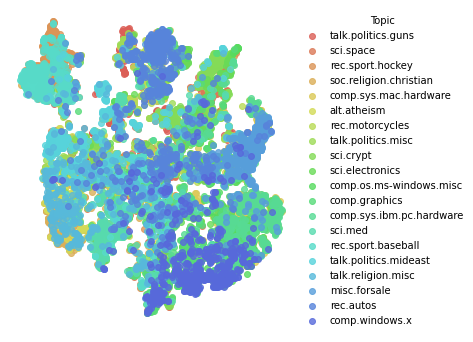

In [30]:
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
tsne_results = tsne.fit_transform(predictions)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsnedf = pd.DataFrame()
tsnedf['tsne-2d-one'] = tsne_results[:,0]
tsnedf['tsne-2d-two'] = tsne_results[:,1]
tsnedf['Topic']=topicnames
plt.figure(figsize=(25,25))
sns.lmplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='Topic',
    palette=sns.color_palette("hls", NUM_TOPICS),
    data=tsnedf,
    legend="full",
    fit_reg=False
)
plt.axis('Off')
plt.show()

The TSNE plot should show some large topic clusters like the following image. Plots like these can be used to extract the number of distinct topic clusters in the dataset. Currently, NUM_TOPICS is set to 30, but there appear to be a lot of topics that are close to each other in the TSNE plot and may be combined into a single topic. Ultimately, as topic modeling is largely an unsupervised learning problem, you must use visualizations such as these to determine what is the right number of topics to partition the dataset into.

Try experimenting with different topic numbers to see what the visualization looks like.

## Train and deploy the content recommendation model

In this module, you use the built-in Amazon SageMaker k-Nearest Neighbors (k-NN) Algorithm to train the content recommendation model.

[Amazon SageMaker K-Nearest Neighbors (k-NN)](https://docs.aws.amazon.com/sagemaker/latest/dg/k-nearest-neighbors.html) is a non-parametric, index-based, supervised learning algorithm that can be used for classification and regression tasks. For classification, the algorithm queries the k closest points to the target and returns the most frequently used label of their class as the predicted label. For regression problems, the algorithm returns the average of the predicted values returned by the k closest neighbors.

Training with the k-NN algorithm has three steps: sampling, dimension reduction, and index building. Sampling reduces the size of the initial dataset so that it fits into memory. For dimension reduction, the algorithm decreases the feature dimension of the data to reduce the footprint of the k-NN model in memory and inference latency. We provide two methods of dimension reduction methods: random projection and the fast Johnson-Lindenstrauss transform. Typically, you use dimension reduction for high-dimensional (d >1000) datasets to avoid the “curse of dimensionality” that troubles the statistical analysis of data that becomes sparse as dimensionality increases. The main objective of k-NN's training is to construct the index. The index enables efficient lookups of distances between points whose values or class labels have not yet been determined and the k nearest points to use for inference.
In the following steps, you specify your k-NN algorithm for the training job, set the hyperparameter values to tune the model, and run the model. Then, you deploy the model to an endpoint managed by Amazon SageMaker to make predictions.

### 1. Create and run the training job

In the previous module, you created topic vectors. In this module, you build and deploy the content recommendation module which retains an index of the topic vectors.

First, create a dictionary which links the shuffled labels to the original labels in the training data.

In [31]:
labels = newidx 
labeldict = dict(zip(newidx,idx))

labeldict

{10740: 0,
 6572: 1,
 6839: 2,
 354: 3,
 1641: 4,
 5200: 5,
 7625: 6,
 10838: 7,
 1954: 8,
 8421: 9,
 6805: 10,
 5134: 11,
 6853: 12,
 723: 13,
 3380: 14,
 6203: 15,
 7585: 16,
 8866: 17,
 5021: 18,
 10154: 19,
 1609: 20,
 3924: 21,
 10744: 22,
 5870: 23,
 136: 24,
 5396: 25,
 681: 26,
 9185: 27,
 1936: 28,
 7656: 29,
 10877: 30,
 3457: 31,
 8761: 32,
 9945: 33,
 6434: 34,
 668: 35,
 7274: 36,
 4256: 37,
 9926: 38,
 6627: 39,
 3881: 40,
 10920: 41,
 9179: 42,
 2401: 43,
 562: 44,
 9327: 45,
 3619: 46,
 4090: 47,
 4543: 48,
 5311: 49,
 2189: 50,
 7770: 51,
 9026: 52,
 3112: 53,
 10623: 54,
 6776: 55,
 1606: 56,
 11221: 57,
 3688: 58,
 4597: 59,
 10242: 60,
 2834: 61,
 9755: 62,
 1529: 63,
 10603: 64,
 296: 65,
 2643: 66,
 6674: 67,
 9828: 68,
 9298: 69,
 5421: 70,
 2142: 71,
 9633: 72,
 1955: 73,
 22: 74,
 6234: 75,
 1053: 76,
 930: 77,
 7407: 78,
 11251: 79,
 3095: 80,
 3453: 81,
 9045: 82,
 4330: 83,
 8176: 84,
 8430: 85,
 2358: 86,
 11118: 87,
 2241: 88,
 464: 89,
 713: 90,
 9902: 91

Next, store the training data in your S3 bucket using the following code:

In [34]:
import io
import sagemaker.amazon.common as smac


print('train_features shape = ', predictions.shape)
print('train_labels shape = ', labels.shape)
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, predictions, labels)
buf.seek(0)

bucket = BUCKET
prefix = PREFIX
key = 'knn/train'
fname = os.path.join(prefix, key)
print(fname)
boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

train_features shape =  (11314, 30)
train_labels shape =  (11314,)
20newsgroups/knn/train
uploaded training data location: s3://sagemaker-recom-bucket/20newsgroups/knn/train


Next, use the following helper function to create a k-NN estimator much like the NTM estimator you created in Module 3.

In [35]:
def trained_estimator_from_hyperparams(s3_train_data, hyperparams, output_path, s3_test_data=None):
    """
    Create an Estimator from the given hyperparams, fit to training data, 
    and return a deployed predictor
    
    """
    # set up the estimator
    knn = sagemaker.estimator.Estimator(get_image_uri(boto3.Session().region_name, "knn"),
        get_execution_role(),
        train_instance_count=1,
        train_instance_type='ml.m4.xlarge',
        output_path=output_path,
        sagemaker_session=sagemaker.Session(),
        use_spot_instances=True,# Shared instances amount of time we can wait for instance to be available
        max_run=300,
        max_wait=600)
    knn.set_hyperparameters(**hyperparams)
    
    # train a model. fit_input contains the locations of the train and test data
    fit_input = {'train': s3_train_data}
    knn.fit(fit_input)
    return knn

hyperparams = {
    'feature_dim': predictions.shape[1],
    'k': NUM_NEIGHBORS,
    'sample_size': predictions.shape[0],
    'predictor_type': 'classifier' ,
    'index_metric':'COSINE'
}
output_path = 's3://' + bucket + '/' + prefix + '/knn/output'
knn_estimator = trained_estimator_from_hyperparams(s3_train_data, hyperparams, output_path)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2022-03-03 12:41:58 Starting - Starting the training job...
2022-03-03 12:42:25 Starting - Preparing the instances for trainingProfilerReport-1646311318: InProgress
.........
2022-03-03 12:43:48 Downloading - Downloading input data...
2022-03-03 12:44:22 Training - Downloading the training image...............
2022-03-03 12:47:00 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/03/2022 12:47:02 INFO 140286078224192] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'_kvstore': 'dist_async', '_log_level': 'info', '_num_gpus': 'auto', '_num_kv_servers': '1', '_tuning_objective_metric': '', '_faiss_index_nprobe': '5', 'epochs': '1', 'feature_dim': 'auto', 'faiss_index_ivf_nlists': 'auto', 'index_metric': 'L2', 'index_type': 'faiss.Flat', 'mini_batch_size': '5000', '_enable_profiler': 'false'}
[03/03/2022 1

While the training job runs, take a closer look at the parameters in the helper function.

The Amazon SageMaker k-NN algorithm offers a number of different distance metrics for calculating the nearest neighbors. One popular metric that is used in natural language processing is the cosine distance. Mathematically, the cosine “similarity” between two vectors A and B is given by the following equation:

![similarity](content-rec-cosine.png)

By setting the index_metric to COSINE, Amazon SageMaker automatically uses the cosine similarity for computing the nearest neighbors. The default distance is the L2 norm, which is the standard Euclidean distance. Note that, at publication, COSINE is only supported for faiss.IVFFlat index type and not the faiss.IVFPQ indexing method.

Success! Since you want this model to return the nearest neighbors given a particular test topic, you need to deploy it as a live hosted endpoint.

### 2. Deploy the content recommendation model

As you did with the NTM model, define the following helper function for the k-NN model to launch the endpoint. In the helper function, the accept token **applications/jsonlines; verbose=true** tells the k-NN model to return all the cosine distances instead of just the closest neighbor. To build a recommendation engine, you need to get the top-k suggestions by the model, for which youneed to set the verbose parameter to **true**, instead of the default, false.

In [41]:
#accept="application/jsonlines; verbose=true",
def predictor_from_estimator(knn_estimator, estimator_name, instance_type, endpoint_name=None): 
    
    
    knn_predictor = knn_estimator.deploy(initial_instance_count=1, instance_type=instance_type,
                               endpoint_name=endpoint_name,
                               serializer=CSVSerializer(),
                               deserializer=JSONDeserializer())
    #knn_predictor.content_type = 'text/csv'
    #knn_predictor.serializer = csv_serializer
    #knn_predictor.deserializer = json_deserializer
    return knn_predictor
import time

instance_type = 'ml.m4.xlarge'
model_name = 'knn_%s'% instance_type
endpoint_name = 'knn-ml-m4-xlarge-%s'% (str(time.time()).replace('.','-'))
print('setting up the endpoint..')
knn_predictor = predictor_from_estimator(knn_estimator, model_name, instance_type, endpoint_name=endpoint_name)

setting up the endpoint..
-------------!

Next, preprocess the test data so that you can run inferences.
Copy and paste the following code into your notebook and choose Run.

In [47]:
result

{'predictions': [{'predicted_label': 699.0}]}

In [42]:
def preprocess_input(text):
    text = strip_newsgroup_header(text)
    text = strip_newsgroup_quoting(text)
    text = strip_newsgroup_footer(text)
    return text    
    
test_data_prep = []
for i in range(len(newsgroups_test)):
    test_data_prep.append(preprocess_input(newsgroups_test[i]))
test_vectors = vectorizer.fit_transform(test_data_prep)

test_vectors = np.array(test_vectors.todense())
test_topics = []
for vec in test_vectors:
    test_result = ntm_predictor.predict(vec)
    test_topics.append(test_result['predictions'][0]['topic_weights'])

topic_predictions = []
for topic in test_topics:
    result = knn_predictor.predict(topic)
    cur_predictions = np.array([int(result['labels'][i]) for i in range(len(result['labels']))])
    topic_predictions.append(cur_predictions[::-1][:10]) 

KeyError: 'labels'

In the last step of this module, you explore your content recommendation model.

### 3. Explore content recommendation model

Now that you've obtained the predictions, you can plot the topic distributions of the test topics, compared to the closest k topics recommended by the k-NN model.

In [ ]:
# set your own k.
def plot_topic_distribution(topic_num, k = 5):
    
    closest_topics = [predictions[labeldict[x]] for x in topic_predictions[topic_num][:k]]
    closest_topics.append(np.array(test_topics[topic_num]))
    closest_topics = np.array(closest_topics)
    df = pd.DataFrame(closest_topics.T)
    df.rename(columns ={k:"Test Document Distribution"}, inplace=True)
    fs = 12
    df.plot(kind='bar', figsize=(16,4), fontsize=fs)
    plt.ylabel('Topic assignment', fontsize=fs+2)
    plt.xlabel('Topic ID', fontsize=fs+2)
    plt.show()

Run the following code to plot the topic distribution:

In [ ]:
plot_topic_distribution(18)

Now, try some other topics. Run the following code cells:

In [ ]:
plot_topic_distribution(25)

In [ ]:
plot_topic_distribution(5000)

Your plots may look somewhat different based on the number of topics (NUM_TOPICS) you choose. But overall, these plots show that the topic distribution of the nearest neighbor documents found using Cosine similarity by the k-NN model is pretty similar to the topic distribution of the test document we fed into the model.

The results suggest that k-NN may be a good way to build a semantic based information retrieval system by first embedding the documents into topic vectors and then using a k-NN model to serve the recommendations.